In [1]:
import sys
from pathlib import Path

here = Path.cwd().resolve()
repo_root = here if (here / "src").exists() else here.parents[1]

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

In [2]:
import torch

In [3]:
def generate_text_simple(model, max_new_tokens, idx, context_size):
    # model is assumed to be in eval mode
    # max_new_tokens: number of tokens to generate (addition to the input tokens)
    # idx is (B, T) tensor of indices in the input sequence
    # context_size: maximum context size for the model (while generating only the last context_size tokens are fed to the model)
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [7]:
import tiktoken 
tokenizer = tiktoken.get_encoding("gpt2")

In [10]:
input_context = "Hello, I am"
encoded_input = tokenizer.encode(input_context)
print("Encoded input:", encoded_input)
encoded_tensor = torch.tensor(encoded_input).unsqueeze(0)  # Add batch dimension
print("Encoded tensor shape:", encoded_tensor.shape)


Encoded input: [15496, 11, 314, 716]
Encoded tensor shape: torch.Size([1, 4])


In [12]:
from src.gpt_blocks.gpt_model import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "embed_dim": 768,
    "n_layers": 12,
    "n_heads": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [13]:
model = GPTModel(GPT_CONFIG_124M)

In [19]:
model.eval()
out = generate_text_simple(model, max_new_tokens=10, idx=encoded_tensor, context_size=GPT_CONFIG_124M["context_length"])
print("Generated token indices:", out)
print("Output shape:", out.shape)

Generated token indices: tensor([[15496,    11,   314,   716,  6463, 38941, 47329,  8246, 13119, 14434,
         29800, 39652,  5521, 19323]])
Output shape: torch.Size([1, 14])


In [20]:
decoded_output = tokenizer.decode(out.squeeze(0).tolist())
print("Decoded output:", decoded_output)

Decoded output: Hello, I am cannBloomelope raw playoff transformedMulti Gael Work runners


In [21]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [22]:
start_context = "Every Effort moves you"


In [24]:
token_ids=generate_text_simple(model=model, max_new_tokens=10, idx=text_to_token_ids(start_context, tokenizer), context_size=GPT_CONFIG_124M["context_length"])

In [25]:
print("Generated text:", token_ids_to_text(token_ids, tokenizer))

Generated text: Every Effort moves you Legendolean debugger Gleaming eurozone fared consolation claws ops cle


#Loss calculation

In [27]:
inputs = ["every effort moves", "I really like"]
input_tensors = torch.empty((0, 0))
for input in inputs:
    tensor = text_to_token_ids(input, tokenizer)
    input_tensors = torch.cat((input_tensors, tensor), dim=0) if input_tensors.numel() else tensor



In [28]:
input_tensors

tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])

In [29]:
targets = [" effort moves you", "really like pizza"]
targets_tensors = torch.empty((0, 0))
for target in targets:
    tensor = text_to_token_ids(target, tokenizer)
    targets_tensors = torch.cat((targets_tensors, tensor), dim=0) if targets_tensors.numel() else tensor

In [30]:
targets_tensors

tensor([[ 3626,  6100,   345],
        [27485,   588, 14256]])

In [31]:
with torch.no_grad():
    logits = model(input_tensors)

probas = torch.softmax(logits, dim=-1)
print("Probabilities shape:", probas.shape)  # Should be (B, T, vocab_size)

Probabilities shape: torch.Size([2, 3, 50257])


In [37]:
probas

tensor([[[3.7496e-05, 1.5021e-05, 7.0548e-06,  ..., 1.3383e-05,
          1.2019e-05, 1.2897e-05],
         [1.2830e-05, 1.4814e-05, 1.8311e-05,  ..., 4.6096e-06,
          1.3831e-05, 4.8681e-05],
         [1.4558e-05, 1.7351e-05, 2.1696e-05,  ..., 5.2209e-06,
          4.2133e-05, 2.8533e-05]],

        [[1.6197e-05, 9.6398e-06, 1.5415e-05,  ..., 1.3181e-05,
          1.4125e-05, 1.9335e-05],
         [2.1766e-05, 1.7325e-05, 4.5895e-05,  ..., 8.0432e-06,
          4.2441e-05, 2.4999e-05],
         [1.3816e-05, 2.3339e-05, 1.4093e-05,  ..., 5.6741e-06,
          2.3422e-05, 2.1280e-05]]])

In [32]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[36015],
         [41170],
         [42429]],

        [[25319],
         [39766],
         [44255]]])


In [38]:
targets_tensors[0]

tensor([3626, 6100,  345])

In [34]:
print(f"Targets batch 1: {token_ids_to_text(targets_tensors[0], tokenizer)}")
print(f"Outputs batch 1:"
f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Kimber Morph Osaka


In [43]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets_tensors[text_idx]] # Get probabilities for the target tokens in the first batch
print("Text 1:", target_probas_1)
print("Shape:", target_probas_1.shape)

Text 1: tensor([1.2019e-05, 2.2360e-05, 1.5667e-05])
Shape: torch.Size([3])


In [45]:
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets_tensors[text_idx]]
print("Text 2:", target_probas_2)

Text 2: tensor([3.6553e-05, 2.4526e-05, 4.2677e-06])


In [46]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-11.3290, -10.7082, -11.0639, -10.2167, -10.6158, -12.3644])


In [47]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-11.0497)


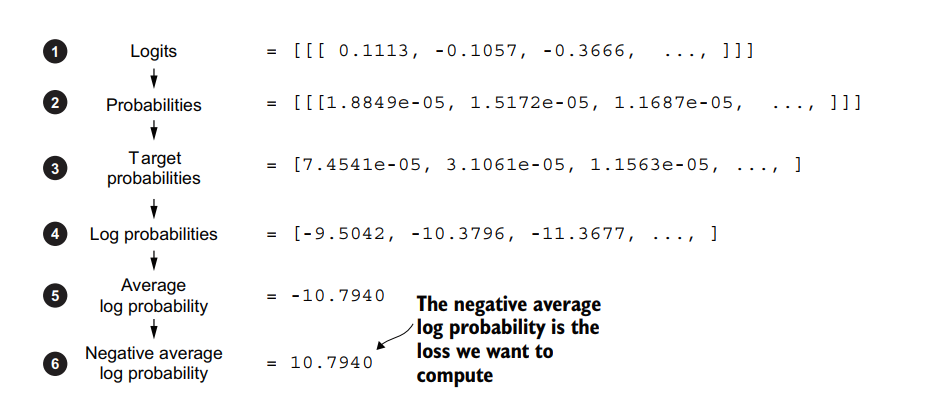

In [48]:
#batch loss
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(11.0497)


In [49]:
# can use cross entropy loss function in pytorch

print("Logits shape:", logits.shape)
print("Targets shape:", targets_tensors.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [51]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets_tensors.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [52]:
targets_flat

tensor([ 3626,  6100,   345, 27485,   588, 14256])

In [53]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

In [54]:
print(loss)

tensor(11.0497)
